In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as Tfidf
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import LinearSVC

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

First, we'll read the raw reviews from our Yelp JSON dataset, flatten the "votes" subobject into "cool" "funny" and "useful" attributes, then cast it to a pandas Dataframe.

In [3]:
data = []
with open('reviews.json') as f:
    for line in f:
        data.append(json.loads(line))

reviews = []
for rev in data:
    rev['cool'] = rev['votes']['cool']
    rev['funny'] = rev['votes']['funny']
    rev['useful'] = rev['votes']['useful']
    del rev['votes']
    reviews.append(rev)
    
reviews = pd.DataFrame(reviews)

Our next step is to clean the reviews by removing duplicates. After doing so, we'll extract all reviews made during 2015 to comprise our model's sample.

In [ ]:
reviews.duplicated(subset=['business_id', 'text', 'date', 'user_id'])
before = reviews.shape[0]
reviews = reviews.drop(reviews[reviews.duplicated(subset=['business_id', 'text', 'date', 'user_id'])].index)
after = reviews.shape[0]

print before - after, "duplicates dropped"

reviews_2015 = reviews[(reviews['date'] >= '2015-01-01') & (reviews['date'] < '2016-01-01')]
del reviews_2015['review_id']
del reviews_2015['type']

print reviews_2015.shape
reviews_2015.to_json("json_2015.json", orient='records')

Let's briefly inspect the data to ensure that everything looks right. Note that the CSV read/write operation is in place because the notebook was originally split into a cleaning notebook and a modeling notebook.

In [6]:
data = pd.read_json('json_2015.json')
data.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,vT12uXtdBQ10_lUcl-M40w,0,2015-01-01,0,1,terrible experience....I am a local first of a...,0,C_xtIn19eKivN335dzjadg
1,aWMxTWSEqBvH2KhdGPLibQ,0,2015-01-01,0,3,Bad service at this location.\n\nGood iced cof...,0,T7J9ae0wTskrI_Bgwp-4cA
2,Z98h1BhssZeFfZvcVTYOpw,0,2015-01-01,0,2,We have been to Maya's many times since it fir...,1,O7WaUuYwX45Ia6Mvf01UCw
3,3rwM9fPYPk9qDkEBOhyHbg,1,2015-01-01,0,5,"booked the hotel for new years, over the phone...",1,kq-4vbC1cHQbRKyDmwERSA
4,JpYn_HdxQNZQSlWWv4P6Iw,0,2015-01-01,0,3,"Good, not great. Not a ton of tea options but ...",1,XweddetOpWNuJQ5mLb_5JQ


Looks good. Let's sample from this subset of 2015 reviews so that our model is a bit easier to work with.

In [7]:
samp = data.sample(50000) #draw samples

We'll now establish our baseline model. For this we'll use a very basic vectorizer with no weighting or other such modifications.

In [8]:
vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = samp.text.values

#tokenize words
x = vectorizer.fit_transform(reviews)

Converting response variable for "useful" to binary form. In other words, reviews with at least one useful vote are labeled as "1" while those without are labeled as "0".

In [9]:
binary_y = [] #class observations according to whether they have at least one "helpful" vote

for score in samp.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

Let's find the optimal logistic regression regularization parameter for this dataset. It appears to be about 0.01, further tinkering yielded no additional gains.

C= 0.0001 : 0.646140014067
C= 0.001 : 0.662779856527
C= 0.01 : 0.66393987653
C= 0.1 : 0.653520002091
C= 1 : 0.627160042005
C= 10 : 0.606280070737
C= 100 : 0.600379882726


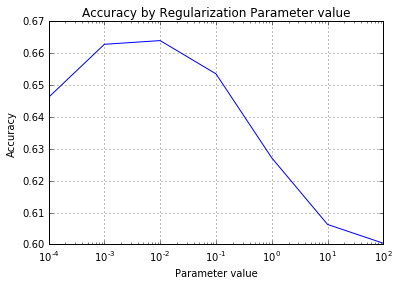

In [10]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x, binary_y, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [11]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
print "Cross Validated Accuracy on Sample:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()

Cross Validated Accuracy on Sample: 0.66393987653


Hmm, not a bad number. However, we should look at how this model fails

In [12]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "NO CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

#BALANCED CLASSES
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

NO CLASS BALANCE CORRECTION
[[28903  2247]
 [12761  6089]]

False Positive Rate: 0.0721348314607
False Negative Rate: 0.676976127321
True Positive Rate: 0.730446257198
True Negative Rate: 0.693716397849

Accuracy on Positive Reviews: 0.323023872679
Accuracy on Negative Reviews: 0.927865168539
Overall F1 Score: 0.377639697816


WITH CLASS BALANCE CORRECTION
[[24119  7031]
 [ 8301 10549]]

False Positive Rate: 0.225714285714
False Negative Rate: 0.440371352785
True Positive Rate: 0.600056882821
True Negative Rate: 0.743954349167

Accuracy on Positive Reviews: 0.559628647215
Accuracy on Negative Reviews: 0.774285714286
Overall F1 Score: 0.512523895903


It appears that the highly imbalanced classes were the cause for our high initial cross validated accuracy. Weighting improves our accuracy on the positive reviews, but the model is still relatively weak. We'll look at some more advanced techniques for improving overall accuracy and positive accuracy rate after running the baseline algorithm on the full dataset.

In [13]:
#same procedure on full dataset

vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = data.text.values
x = vectorizer.fit_transform(reviews)

binary_y = []

for score in data.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

In [14]:
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
print "Accuracy:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()
print "F1 Score:",cross_val_score(log_model, x, binary_y, scoring='f1', n_jobs=-1).mean()

log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

Accuracy: 0.655814588905
F1 Score: 0.525511083732


WITH CLASS BALANCE CORRECTION
[[314277 101194]
 [119596 131748]]

False Positive Rate: 0.243564532783
False Negative Rate: 0.475825959641
True Positive Rate: 0.56558284895
True Negative Rate: 0.724352517903

Accuracy on Positive Reviews: 0.524174040359
Accuracy on Negative Reviews: 0.756435467217
Overall F1 Score: 0.525511083732


Overall, while our baseline model establishes some degree of separation between helpful and unhelpful reviews it seems to have a relatively low accuracy and F1 score even when tuned. This is likely due to a confounding element of our question: the reality that reviews can lack "useful" votes for multiple reasons. 

On one hand, a review can have no useful votes when it actually contains useless content. This is the sort of review we'd like to classify as 0 or useless. On the other hand, a great review can recieve no useful votes simply because it goes unnoticed by other Yelp users. This likely impedes our model's capacity to make solid predictions regarding a review's helpfulness. A "denominator" value such as the sort seen in the Amazon dataset we looked at previously would help alleviate this issue.

Given this difficulty, it will make sense for us to fit some additional models to the data to see which works best. Playing with class weights would also make sense, as the model currently seems to be making a fair number of false negative errors (which are severely impacting its performance).

In [2]:
data = pd.read_json('json_2015.json')
data = data.sample(frac=1)

In [3]:
data.head()

,business_id,cool,date,funny,stars,text,useful,user_id
535690,mTLxc3DqWqFk0D2mijfuBw,0,2015-10-18,0,3,Went here with boyfriend last night at his rec...,1,sbmv5VijXRk6Hc1tZXWTfw
17945,_PuhheIPgmDCBJe1nhpKTg,0,2015-01-11,1,5,Looking for a good Italian place in Vegas and ...,0,E6MDZx4Eh3JZzyL6J8DPKQ
468801,dz1bfyHR5lOdse4b4UiQiQ,0,2015-09-12,0,1,Ordered a sandwich which they forgot to put sa...,2,4ltmmYvQTtS3Um3UWvjBRg
603586,MmNuDDHUHDgLj4BviOvlqg,0,2015-11-24,0,1,After years of wanting to replace my worn down...,0,yWaoi5rHDb5b8Lzzh5tJqw
184502,dVk_hKqA4mi0XOJq4pfJiQ,0,2015-04-18,1,1,Not impressed. Yeah having the free vacuums is...,5,NSNyXuGQXpvkpvXqPR7Yjw


The functions below are scorers which calculate our model's accuracy on the different classes

In [4]:
#standardize predictor variables

def scorer_pos(estimator, X, y): #custom scoring functions to get positive and negative accuracy
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    return np.float(np.mean(y_pred[y == 1] == y[y == 1]))

def scorer_neg(estimator, X, y):
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    return np.float(np.mean(y_pred[y == 0] == y[y == 0]))

This function tests a model and returns a wide variety of metrics on its performance.

In [5]:
def test_model(x, binary_y, model, title, coefs=False):
    model.fit(x, binary_y)
    y_pred = model.predict(x)
    binary_y = np.array(binary_y)

    tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

    print title
    print confusion_matrix(binary_y, y_pred)

    print "False Positive Rate:", fp/float(fp+tn)
    print "False Negative Rate:", fn/float(fn+tp)
    print "True Positive Rate:", tp/float(tp+fp)
    print "True Negative Rate:", tn/float(tn+fn)
    
    print "Positive Accuracy:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring=scorer_pos).mean()
    print "Negative Accuracy:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring=scorer_neg).mean()
    print "Cross Validated Accuracy on Sample:", cross_val_score(model, x, binary_y, n_jobs=-1).mean()
    print "Cross Validated AUC on Sample:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring='roc_auc').mean()
    print "Train Set Accuracy on Sample:", np.mean(y_pred == binary_y)
    print
    if coefs == True:
        mydict = zip(model.coef_[0], vectorizer.get_feature_names())
        words = sorted([(i[0], i[1].encode('utf-8')) for i in mydict], reverse=True, key=lambda x: x[0])
        return words

Below is a stemmer drawn from NLTK. We found that it did not noticably increase our model's performace, so we did not end up using it.

In [24]:
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

Here we sample 100,000 reviews from the dataset and run them through a vectorizer using Tf-idf weighting and a non-binary counting mechanism. Document frequency maxima and minima were found to have little effect, and our tokenization process actually worked against us.

In [6]:
samp = data.sample(100000) #draw samples

#lengths = [len(i[1]['text']) for i in samp.iterrows()]

samp.shape
frac_useful = 1 - data['useful'].value_counts()[0] / float(data.shape[0])
frac_funny = 1 - data['funny'].value_counts()[0] / float(data.shape[0])
frac_cool = 1 - data['cool'].value_counts()[0] / float(data.shape[0])

In [13]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             binary=False, 
                             max_features=10000,
                             analyzer='word',
                             #tokenizer=tokenize,
                             sublinear_tf=False
                            ) #using non-binary Count Vec.
reviews = samp.text.values

#tokenize words
x = vectorizer.fit_transform(reviews)

y_useful = [] #class observations according to whether they have at least one "helpful" vote
y_cool = []
y_funny = []


for score in samp.useful.values:
    i = 1 if score > 0 else 0
    y_useful.append(i)

for score in samp.cool.values:
    i = 1 if score > 0 else 0
    y_cool.append(i)

for score in samp.funny.values:
    i = 1 if score > 0 else 0
    y_funny.append(i)

Now let's see how well our algorithm does with these new vectorization techniques

In [14]:
u_tune = 0.00
f_tune = 0.00
c_tune = 0.00

weights = {0:1/(1 - frac_useful + u_tune), 1:1/(frac_useful - u_tune)}
log_model = LogReg(C=0.01, penalty='l2', class_weight=weights) #initialize logistic regression model

rand = RandomForestClassifier(n_estimators=300, criterion='gini', 
                              max_features= 17, max_depth=5, class_weight='balanced')



useful_words = test_model(x, y_useful, 
                          log_model,
                          "Useful",
                          coefs=True)
funny_words = test_model(x, y_funny, 
                         log_model.set_params(class_weight={0:1/(1 - frac_funny + f_tune), 1:1/(frac_funny - f_tune)}), 
                         "Funny",
                          coefs=True)
cool_words = test_model(x, y_cool, 
                        log_model.set_params(class_weight={0:1/(1 - frac_cool + c_tune), 1:1/(frac_cool - c_tune)}),
                        #rand,
                        "Cool",
                          coefs=True)

Useful
[[38773 23462]
 [14005 23760]]
False Positive Rate: 0.376990439463
False Negative Rate: 0.370846021448
True Positive Rate: 0.503155308966
True Negative Rate: 0.734643222555
Positive Accuracy: 0.64498863211
Negative Accuracy: 0.611504780268
Cross Validated Accuracy on Sample: 0.612610008022
Cross Validated AUC on Sample: 0.654538277018
Train Set Accuracy on Sample: 0.62533

Funny
[[52847 29821]
 [ 5835 11497]]
False Positive Rate: 0.360732084966
False Negative Rate: 0.336660512347
True Positive Rate: 0.278256449973
True Negative Rate: 0.900565761221
Positive Accuracy: 0.678975007399
Negative Accuracy: 0.639388880825
Cross Validated Accuracy on Sample: 0.632620023926
Cross Validated AUC on Sample: 0.681813486942
Train Set Accuracy on Sample: 0.64344

Cool
[[52000 26285]
 [ 8740 12975]]
False Positive Rate: 0.335760362777
False Negative Rate: 0.402486760304
True Positive Rate: 0.330489047376
True Negative Rate: 0.856108001317
Positive Accuracy: 0.603914495927
Negative Accuracy: 0.6

The stability of our accuracy numbers has increased, and we see a significant increase in positive class accuracy relative to our baseline model. We found that further biasing the weights in favor of positive classifications caused large drops in negative accuracy, as per our website.

Below are printouts of the 10 highest coefficient words for each class.

In [15]:
print "10 Coolest Words:"
for word in cool_words[:10]:
    print word[1], word[0]

print "\n10 Least Cool Words:"
for word in cool_words[-10:]:
    print word[1], word[0]
    
print "\n10 Funniest Words:"
for word in funny_words[:10]:
    print word[1], word[0]

print "\n10 Least Funny Words:"
for word in funny_words[-10:]:
    print word[1], word[0]
    
print "\n10 Most Useful Words:"
for word in useful_words[:10]:
    print word[1], word[0]

print "\n10 Least Useful Words:"
for word in useful_words[-10:]:
    print word[1], word[0]

10 Coolest Words:
like 0.807612007641
located 0.670322339945
just 0.626328926314
really 0.616388983954
pretty 0.592052005026
vegas 0.567971734863
perfect 0.566693403885
ll 0.559683702614
super 0.528248961115
cream 0.524181983647

10 Least Cool Words:
atmosphere -0.369284364266
told -0.384512134228
recommend -0.3966567704
waited -0.397704357381
horrible -0.399269095416
terrible -0.400473119824
worst -0.473362959253
rude -0.482382202353
service -0.592469353197
food -0.726009765796

10 Funniest Words:
like 1.27323255495
just 0.869431814704
don 0.851679103682
want 0.731578810339
people 0.656238801864
review 0.623923140589
said 0.623217516443
know 0.573615927835
bar 0.564101760505
thing 0.555996253301

10 Least Funny Words:
staff -0.54322547621
excellent -0.603172586984
delicious -0.617626437128
love -0.61820671326
amazing -0.666508852385
food -0.713787452365
best -0.722401827574
recommend -0.752577102822
friendly -0.81210679357
great -1.30580185234

10 Most Useful Words:
like 0.81104191095

Finally, we'll run a linear SVC on the data to see how it performs. Performance is very similar to that of the Logistic Regression, though we ultimately opted to go with the latter for reasons explained on the website.

In [29]:
u_tune = 0.0
f_tune = 0.0
c_tune = 0.0

weights = {0:1/(1 - frac_useful + u_tune), 1:1/(frac_useful - u_tune)}
svm = LinearSVC(C=0.001, penalty='l2', class_weight='balanced') #initialize logistic regression model

rand = RandomForestClassifier(n_estimators=500, criterion='gini', 
                              max_features= 17, max_depth=15, class_weight='balanced_subsample')


useful_words = test_model(x, y_useful, svm, "Useful")
funny_words = test_model(x, y_funny, 
                         svm, "Funny")
cool_words = test_model(x, y_cool, 
                        svm, "Cool")

Useful
[[37961 24225]
 [14053 23761]]
False Positive Rate: 0.389557135046
False Negative Rate: 0.371634844238
True Positive Rate: 0.495165256533
True Negative Rate: 0.729822740032
Positive Accuracy: 0.620510984993
Negative Accuracy: 0.604862843588
Cross Validated Accuracy on Sample: 0.606789924084
Cross Validated AUC on Sample: 0.648357021728
Train Set Accuracy on Sample: 0.61722

Funny
[[51809 30777]
 [ 5808 11606]]
False Positive Rate: 0.37266606931
False Negative Rate: 0.333524750201
True Positive Rate: 0.273836207914
True Negative Rate: 0.899196417724
Positive Accuracy: 0.647524621411
Negative Accuracy: 0.628314709203
Cross Validated Accuracy on Sample: 0.626159901499
Cross Validated AUC on Sample: 0.679360742285
Train Set Accuracy on Sample: 0.63415

Cool
[[50217 27853]
 [ 8835 13095]]
False Positive Rate: 0.356769565774
False Negative Rate: 0.402872777018
True Positive Rate: 0.319795838625
True Negative Rate: 0.850386100386
Positive Accuracy: 0.57528499772
Negative Accuracy: 0.64